# Transformer Series
---

Until around 2019 Recurrent Neural Nets (RNN's) and LSTM's more specifically dominated the NLP domain. Most of the NLP tasks like, machine translation, used LSTM's.

Since 2019 the LSTM's have been largely replaced by Transformer based architectures in the NLP domain. Transformers were intially described in; [Attention is all you need](https://arxiv.org/abs/1706.03762). Transformer based models like BERT and GTP have re-shaped the NLP domains.

They look pretty impressive and complex, but are mainly concepts that were already covered in the example notebooks. If we look at an archictecture diagram, we can see that it is built for sequence to sequence sort of problems. (Seq2Seq models are for instance Machine Translation where we get a sequence of words in one sequence and need to translate return the translation as a sequence of words).

If we build a simple classifier we can focus on the left block of the picture. (I.e. the encoder part). Our classifier architecture will not contain the right part with the outputs embedding as 'input'.

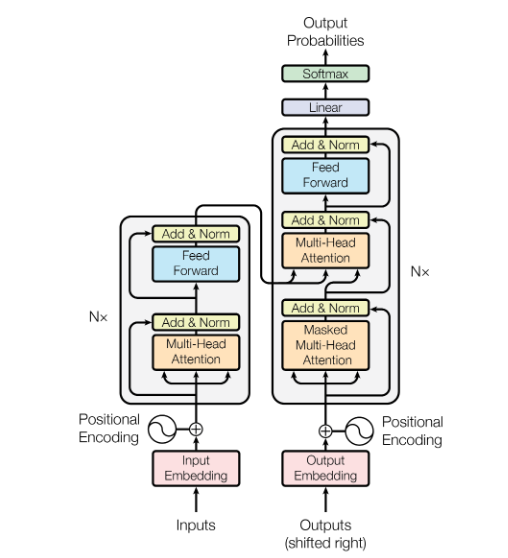

Picture from __Attention is all you need__ by Ashish Vaswani et all [Attention is all you need](https://arxiv.org/abs/1706.03762) Source; *arXiv:1706.03762*


- We can see that we start with an input and run it through an embedding.
- Then we do a process named positional encoding. (More on this later)
- After than we apply attention. The idea of attention is similar to the one explained in an earlier notebook, though that was a simpler implementation that this one. Standard attention here basically reconstruct the entire sequence as a weighted sum over all the series.
- Which is then followed by a set of FeedForward layers.


### Positional Information

ecause transformers use a feedforward main body, we are back to square one where we assume the information about the order of payments gets lost. Transformers solve this by adding in positional information. The original paper uses **Positional Encoding** a rather complex scheme with sine and cosine waves of different frequencies.

As we know the length of our transaction series and it is fixed we will implement a simpler **Positional Embedding**. A positional Embedding will encode the position, we give it the transaction-number as input and the output will be the coordinates of that number. That means the model can learn about the positions. It can position the numbers in the embedding space in a manner that reduces the loss.

In the original implementation the encoding is element-wise added to the original vector. Initial tests with this data showed that this completely distroyed the performance, so we decided to concatenate them on the second dimension. The input to the embedding are numbers 1 to series_length. The output will be matrix of size (series_length, dimension_size).

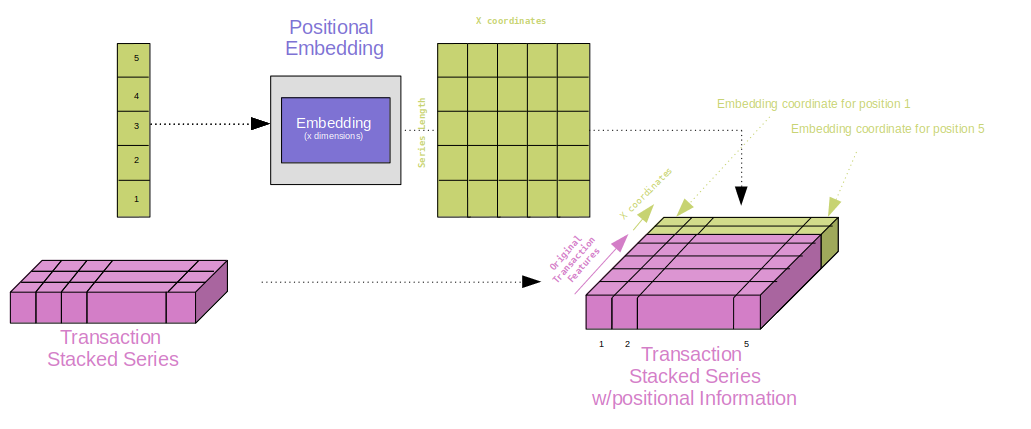

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

### Define Derived Features

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
age_i        = ft.FeatureIndex('age_i', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_i', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_i', ft.FEATURE_TYPE_INT_8, merchant)
category_i   = ft.FeatureIndex('category_i', ft.FEATURE_TYPE_INT_8, category)

# TimeWaves
waves       = ft.FeatureDateTimeWave('time_waves', ft.FEATURE_TYPE_FLOAT_32, date_time, '%j', int(366/2), 2)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

series_size = 5

stacked_ref_series = ft.FeatureSeriesStacked(
    'stacked_ref', ft.FEATURE_TYPE_INT_8, [amount_bin, age_i, gender_i], series_size, merchant
)

# TensorDefinition for the stacked wave
stacked_wave_series = ft.FeatureSeriesStacked(
    'stacked_wave', ft.FEATURE_TYPE_FLOAT_32, [waves], series_size, merchant
)

td_series_ref  = ft.TensorDefinition('stacked_ref', [stacked_ref_series])
td_series_wv   = ft.TensorDefinition('stacked_wave', [stacked_wave_series])
td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series_ref, td_series_wv, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-07-01 17:22:15.647 eng1n3.common.engine           INFO     Start Engine...
2023-07-01 17:22:15.648 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-07-01 17:22:15.648 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-07-01 17:22:15.648 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-07-01 17:22:20.302 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-07-01 17:22:20.311 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_ref using 1 process(es)
2023-07-01 17:22:20.410 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-07-01 17:22:20.411 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 3)]
2023-07-01 17:22:20.411 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_wave using 1 process(es)
2023-07-01 17

In [7]:
ti

TensorInstance with shapes: ((594643, 5, 3), (594643, 5, 4), (594643, 2), (594643, 1))

## Create Data-Sets and Loaders

In [8]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 3), (464643, 5, 4), (464643, 2), (464643, 1))
((30000, 5, 3), (30000, 5, 4), (30000, 2), (30000, 1))
((100000, 5, 3), (100000, 5, 4), (100000, 2), (100000, 1))


## Create Transformer Model

Overall this is very similar to the Recurrent example. But here we have a `Convolutional` layer instead of a recurrent layer.

The convolutional body layer will reduce the output in 2 layers and flatten. 


Then we add the embedding of the referential merchant data (33) 1-D Tensor to the (72,) flattened convolutional series data and end-up with a (105,) size tensor which is then fed to the linear layers.

In [9]:
class BankSimTrans(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimTrans, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        

        # TranformerBody
        self.trans = mp.TransformerBody(
            in_size=self.heads[0].output_size+self.heads[1].output_size,
            series_size=series_size,
            positional_size=8,
            positional_logic='embedding',
            heads=1,
            feedforward_size=32,
            drop_out=0.1            
        )
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[2].output_size+self.trans.output_size, layer_sizes=((16,)), dropout=0.0, bn_interval=1
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        h2 = self.heads[2](x[2])
        # Pass head 0 and 1 (the series) through the ConvBody. Concatenate them first.
        o = torch.cat((h0, h1), dim=2)
        o = self.trans(o)
        # Concatenate to head 2.
        o = torch.cat((h2, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimTrans(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimTrans(
  Number of parameters : 13725. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=SeriesTD, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=SeriesTD, lc=Continuous)
    (2): TensorDefinitionHead(
      Name=referential, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(51, 25)
          (1): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (trans): TransformerBody(
    (pos): PositionalEmbedding(
      series_size=5, positional_size=8
      (pos_embedding): Embedding(5, 8)
    )
    (trans): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantiza

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 197.05it/s]                                                    


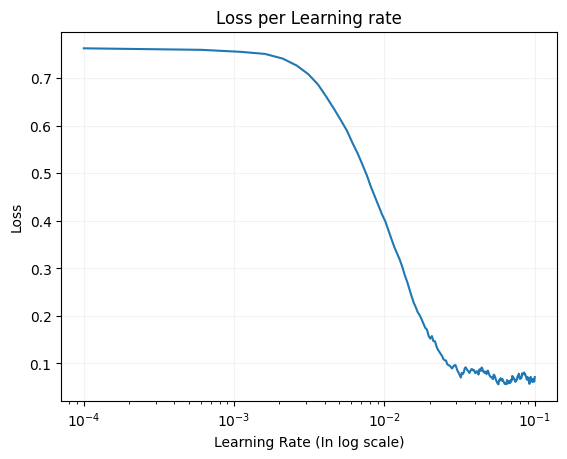

In [10]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimTrans(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [11]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:10<00:00, 359.59it/s, t_loss=0.0424, t_acc=0.985, v_loss=0.0371, v_acc=0.983]    


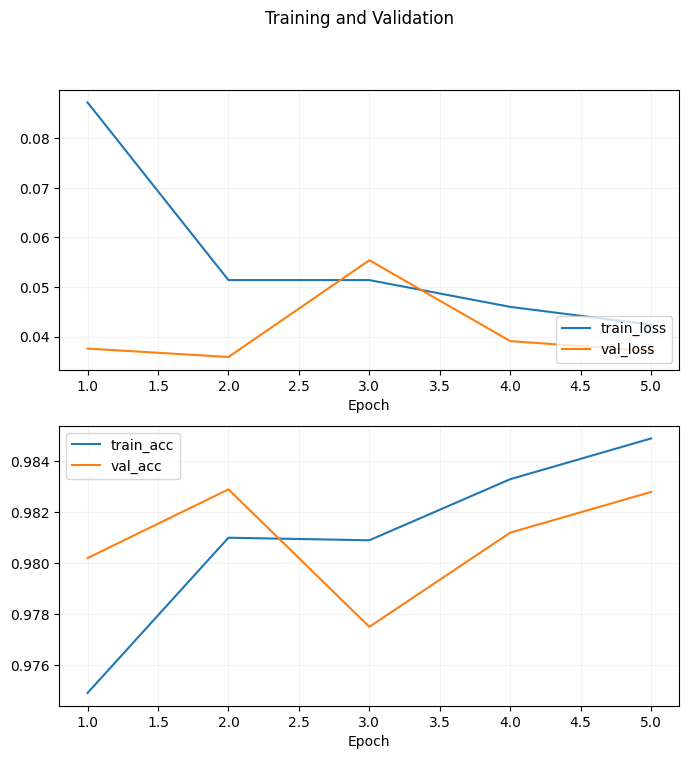

In [12]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

Testing in 782 steps: 100%|██████████████████| 782/782 [00:00<00:00, 830.92it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     98926
         1.0       0.44      0.99      0.61      1074

    accuracy                           0.99    100000
   macro avg       0.72      0.99      0.80    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9989
ap score  : 0.9283
-----------------------------------------------------


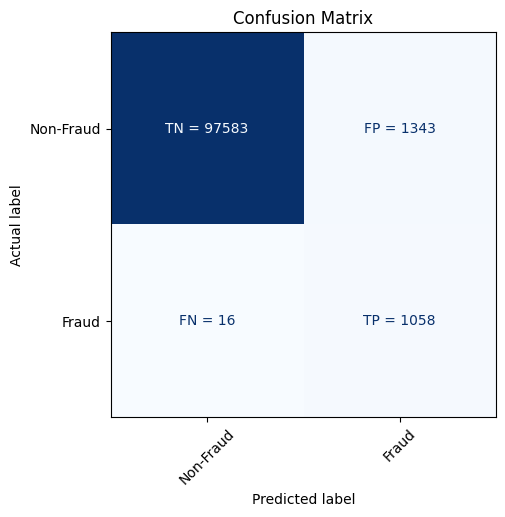

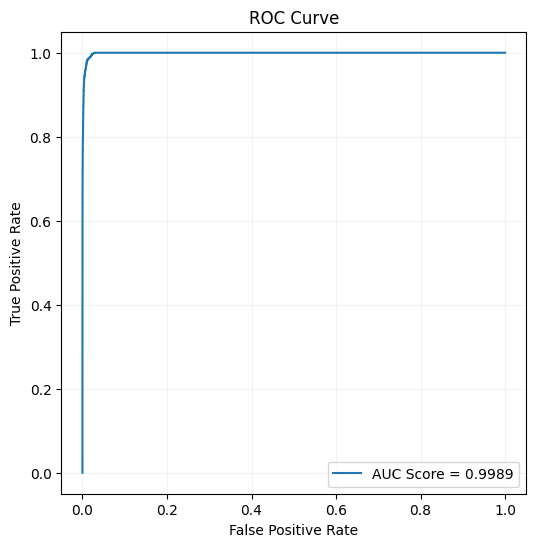

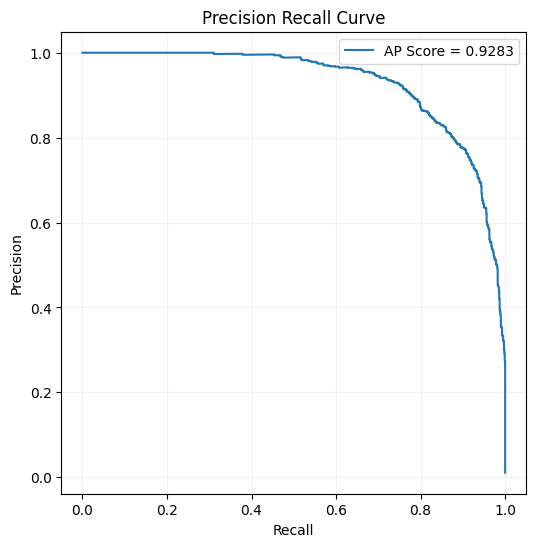

In [13]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))